In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [81]:
df = pd.read_csv('fetal_health.csv', 
               usecols=["accelerations",
                        "fetal_movement",
                        "uterine_contractions",
                        "light_decelerations",
                        "severe_decelerations",
                        "prolongued_decelerations",
                        "abnormal_short_term_variability",
                        "mean_value_of_short_term_variability",
                        "percentage_of_time_with_abnormal_long_term_variability",
                        "mean_value_of_long_term_variability",
                        "fetal_health"])
#I did leave behind some columns that seemed like overcrowding at this point. I will deal with them in the next step of this model.
print(df.shape)
df.head()

(2126, 11)


,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,2.0
1,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,1.0
2,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,1.0
3,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,1.0
4,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,1.0


In [66]:
df.loc[df['fetal_health'] == 1, 'fetal_health'] = 0
df.loc[df['fetal_health'] == 2, 'fetal_health'] = 1
df.loc[df['fetal_health'] == 3, 'fetal_health'] = 2
df['fetal_health'].unique()

array([1., 0., 2.])

C:\Users\PC\Desktop\TFProj\tfvenv\Lib\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


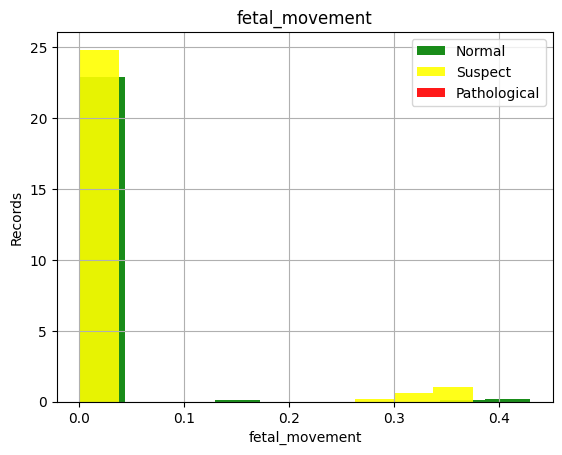

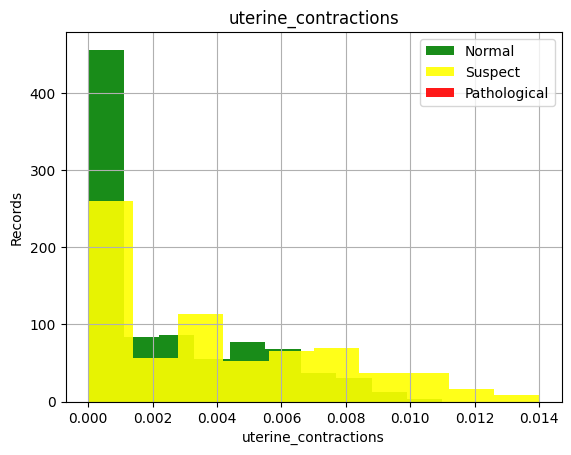

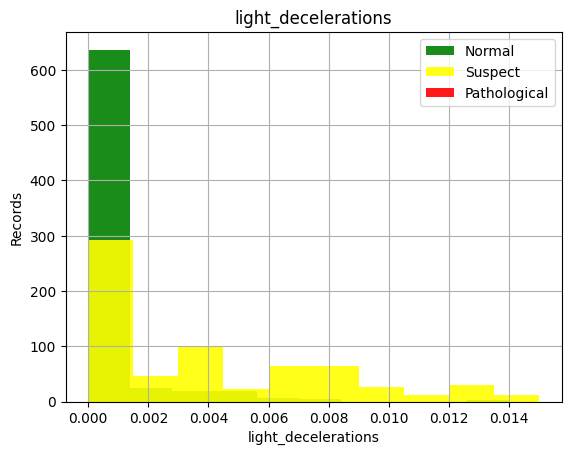

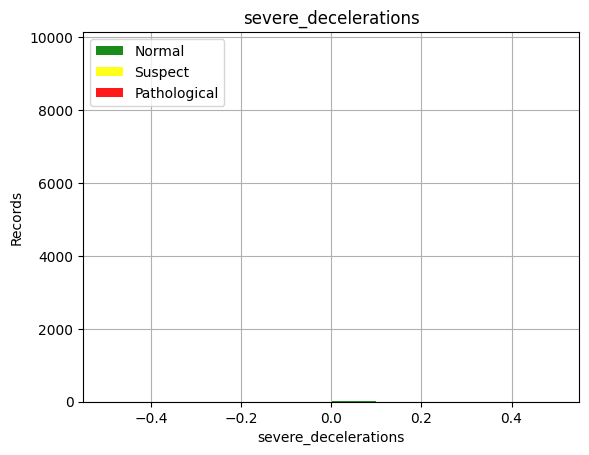

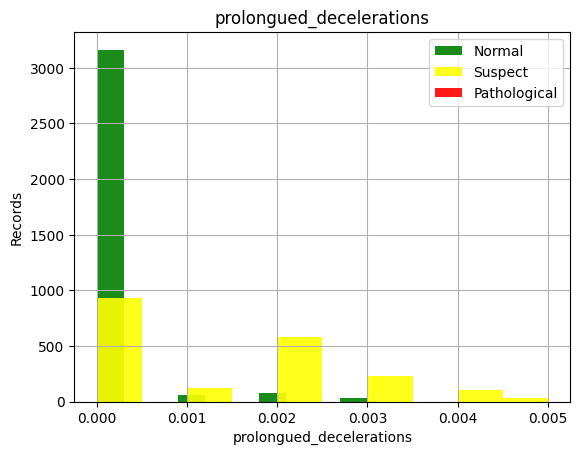

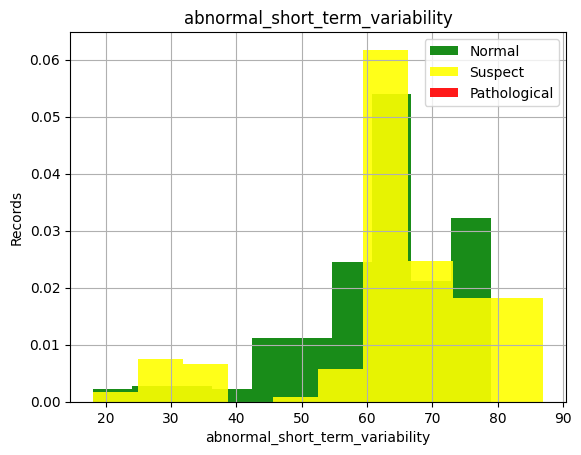

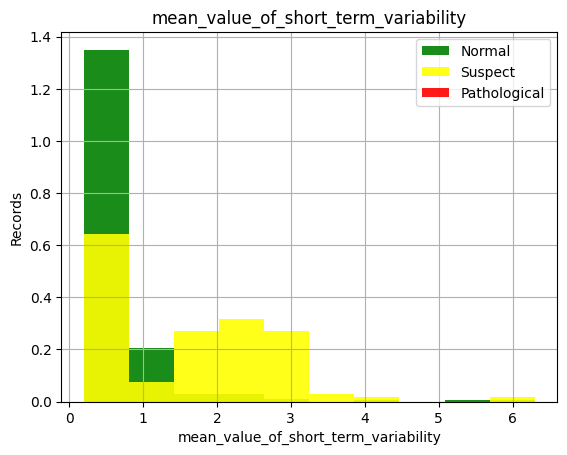

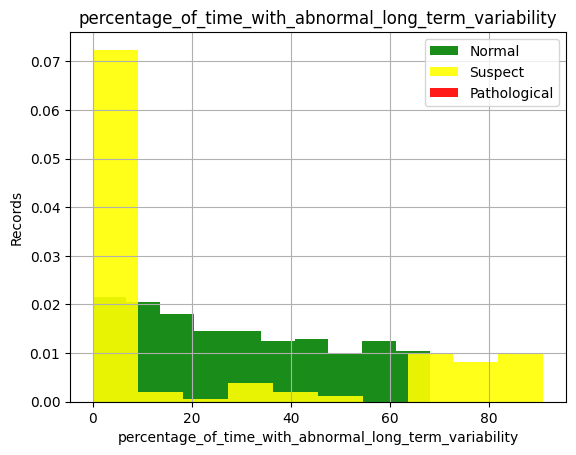

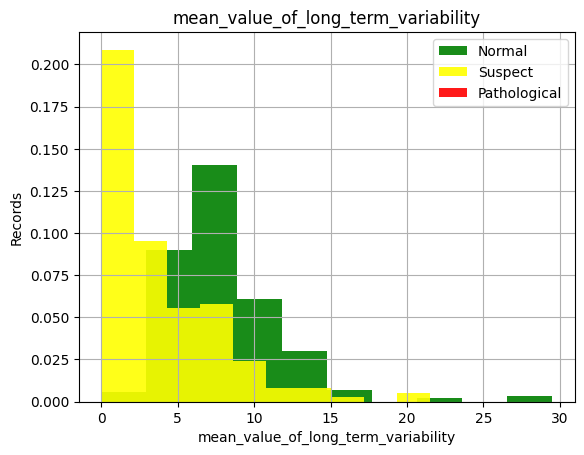

In [68]:
for label in cols[1:-1]:
  plt.hist(df[df['fetal_health']==1][label], color = "green", label = "Normal", alpha = 0.9, density = True)
  plt.hist(df[df['fetal_health']==2][label], color = "yellow", label = "Suspect", alpha = 0.9, density = True)
  plt.hist(df[df['fetal_health']==3][label], color = "red", label = "Pathological", alpha = 0.9, density = True)
  plt.xlabel(label)
  plt.ylabel("Records")
  plt.title(label)
  plt.legend()
  plt.grid()
  plt.show()

TRAIN, VALIDATION AND TEST DATASETS

In [70]:
print(len(df[df['fetal_health']==0]))
print(len(df[df['fetal_health']==1]))
print(len(df[df['fetal_health']==2]))

1655
295
176


Down-Sampling:

In [72]:
indexes_to_remove = df[df['fetal_health'] == 0].sample(n=1350, random_state=42).index
df = df.drop(index=indexes_to_remove).reset_index(drop=True)

In [73]:
print(len(df[df['fetal_health']==0]))
print(len(df[df['fetal_health']==1]))
print(len(df[df['fetal_health']==2]))

305
295
176


In [74]:
train = df.iloc[:int(0.6 * len(df))]
valid = df.iloc[int(0.6 * len(df)):int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]
print(train.shape, valid.shape, test.shape)

(465, 11) (155, 11) (156, 11)


In [75]:
def scale_datasets(dataframe, oversample = False):
  X = dataframe[dataframe.columns[:-1]].values
  Y = dataframe[dataframe.columns[-1]].values.ravel()  # ensures Y is 1D

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, Y = ros.fit_resample(X, Y)

  data = np.hstack((X, np.reshape(Y, (-1, 1))))

  return data, X, Y

In [76]:
train, X_train, Y_train = scale_datasets(train, oversample = True)
valid, X_valid, Y_valid = scale_datasets(valid, oversample = False)
test, X_test, Y_test = scale_datasets(test, oversample = False)

In [78]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3))
  ax1.plot(history.history['loss'], label = "loss")
  ax1.plot(history.history['val_loss'], label = "val_loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Binary Crossentropy")
  ax1.grid(True)
  ax1.legend()

  ax2.plot(history.history['accuracy'], label = "accuracy")
  ax2.plot(history.history['val_accuracy'], label = "val_accuracy")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.grid(True)
  ax2.legend()

  plt.show()

In [85]:
def train_model(X_train, Y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation = "relu", input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob), #this is so that it prevents overfitting
      tf.keras.layers.Dense(num_nodes, activation = "relu"),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(3, activation = "softmax")])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
  history = nn_model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, Y_valid), verbose=0)
  return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


C:\Users\PC\Desktop\TFProj\tfvenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\PC\Desktop\TFProj\tfvenv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


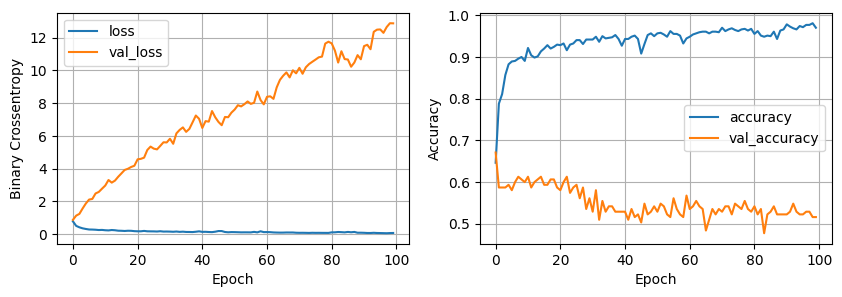

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5453 - loss: 7.7944 
16 nodes, dropout 0, lr 0.01, batch size 64


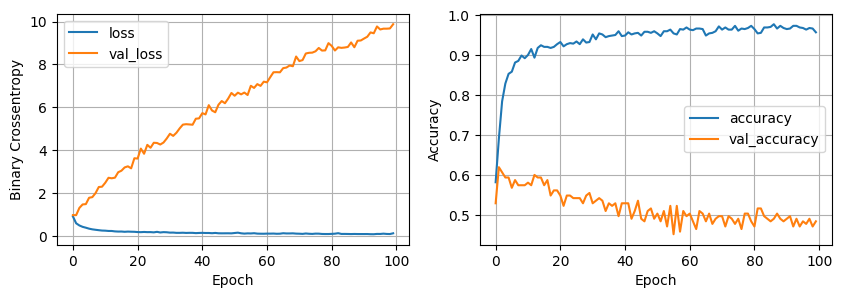

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5784 - loss: 6.7872
16 nodes, dropout 0, lr 0.01, batch size 128


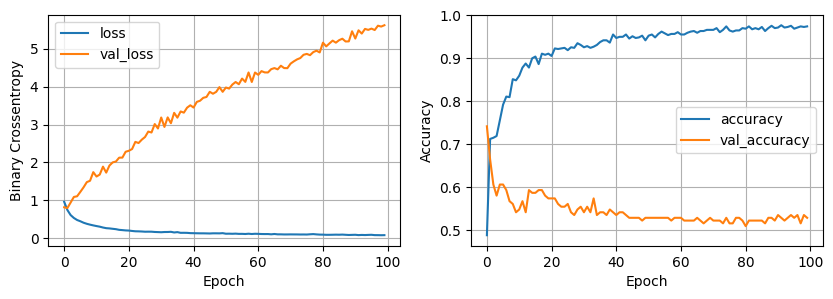

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5874 - loss: 4.1220
16 nodes, dropout 0, lr 0.005, batch size 32


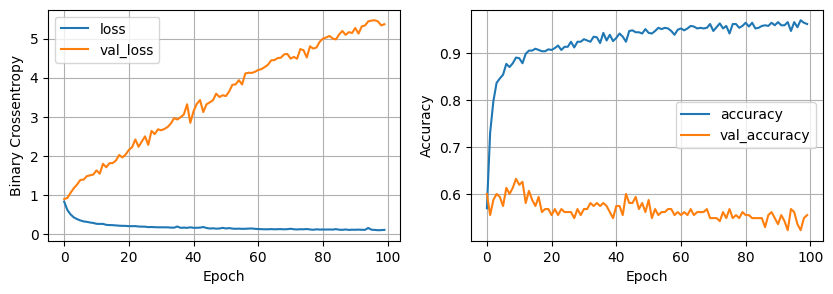

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6107 - loss: 3.6751
16 nodes, dropout 0, lr 0.005, batch size 64


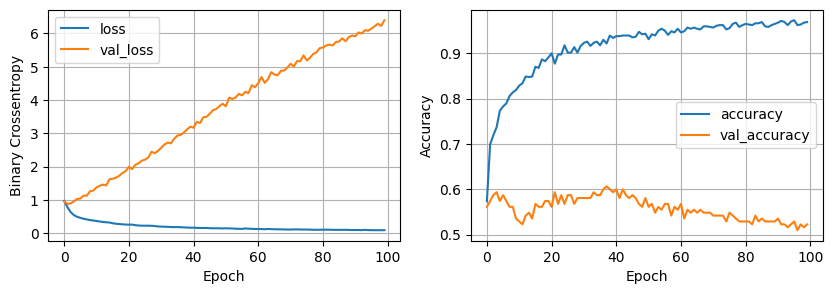

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5974 - loss: 4.1867 
16 nodes, dropout 0, lr 0.005, batch size 128


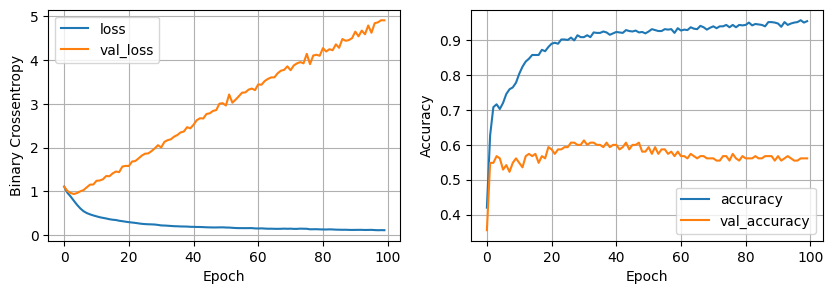

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6137 - loss: 3.3835 
16 nodes, dropout 0, lr 0.001, batch size 32


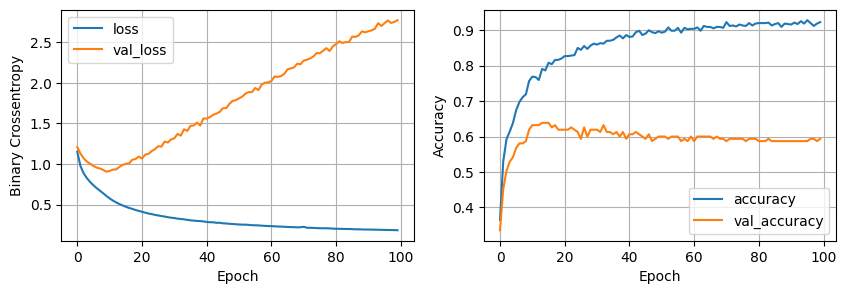

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6375 - loss: 2.0879 
16 nodes, dropout 0, lr 0.001, batch size 64


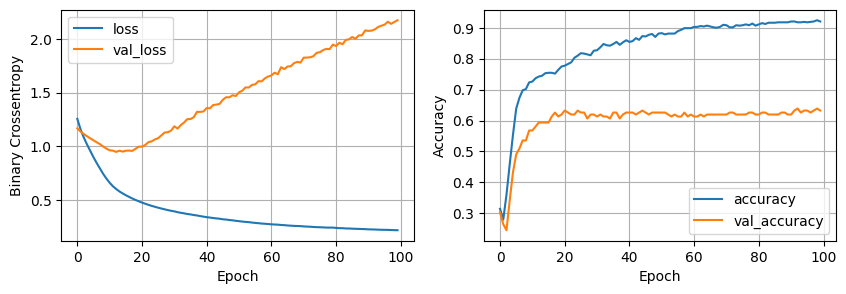

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6791 - loss: 1.6373
16 nodes, dropout 0, lr 0.001, batch size 128


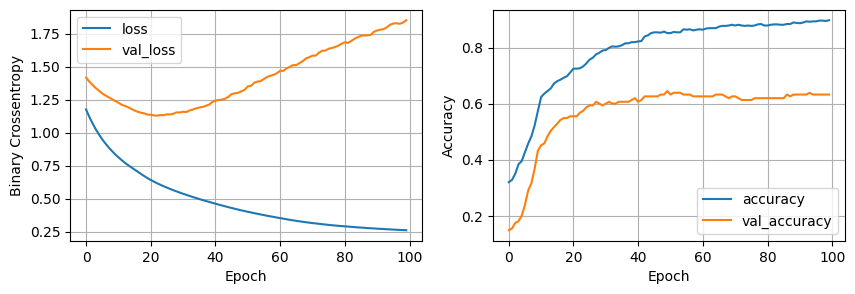

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6791 - loss: 1.4995
16 nodes, dropout 0.2, lr 0.01, batch size 32


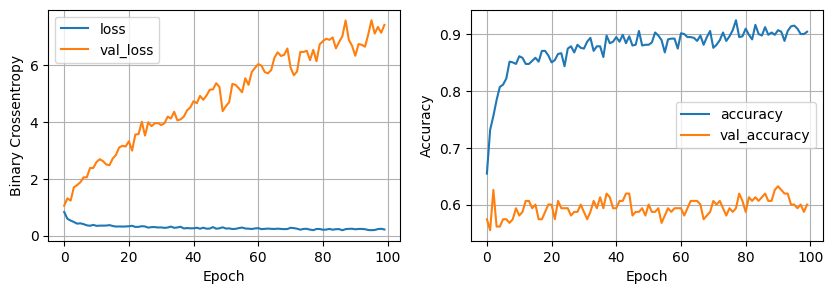

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6388 - loss: 5.0199 
16 nodes, dropout 0.2, lr 0.01, batch size 64


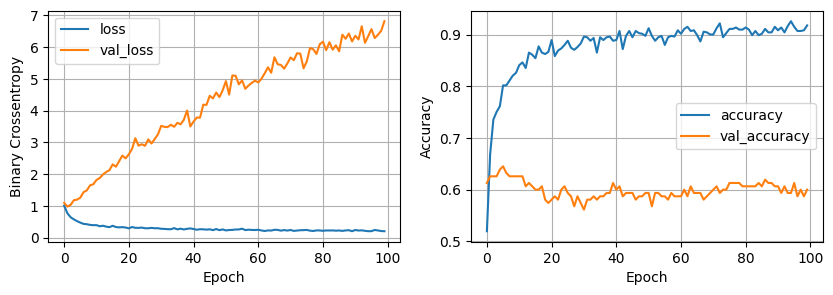

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6405 - loss: 4.4438
16 nodes, dropout 0.2, lr 0.01, batch size 128


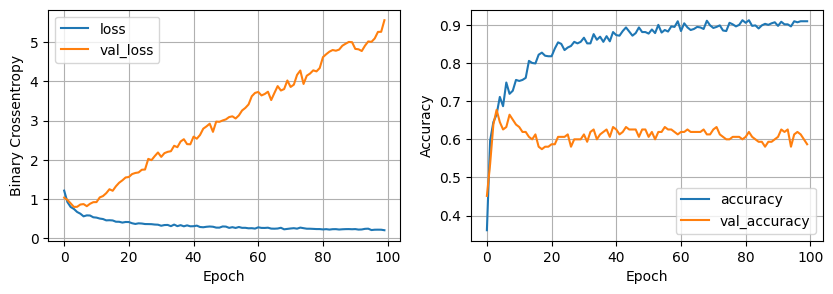

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6250 - loss: 3.5041
16 nodes, dropout 0.2, lr 0.005, batch size 32


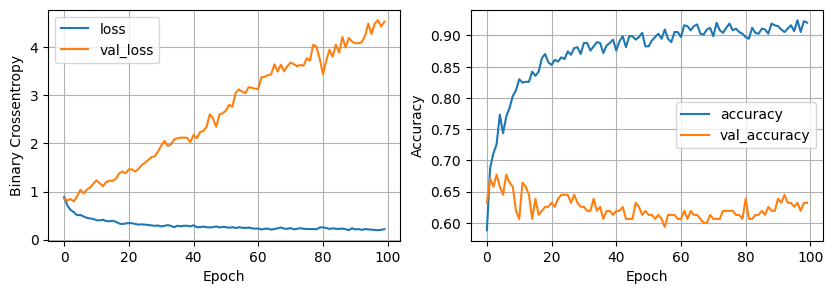

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6678 - loss: 3.0419 
16 nodes, dropout 0.2, lr 0.005, batch size 64


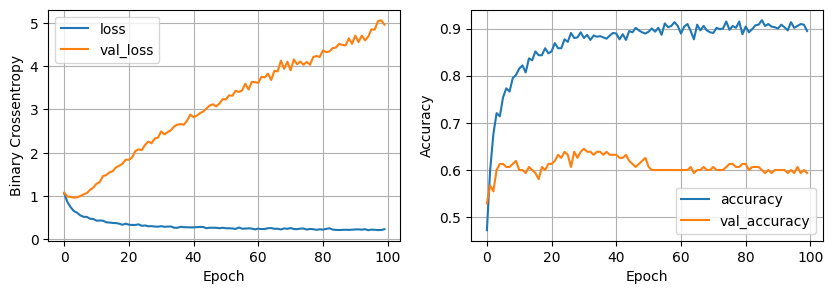

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6449 - loss: 3.4543
16 nodes, dropout 0.2, lr 0.005, batch size 128


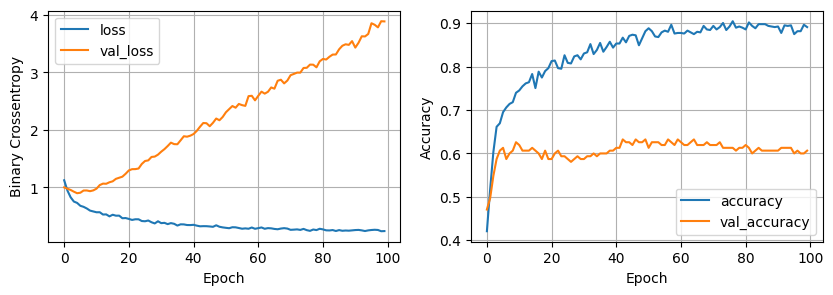

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6501 - loss: 2.6613
16 nodes, dropout 0.2, lr 0.001, batch size 32


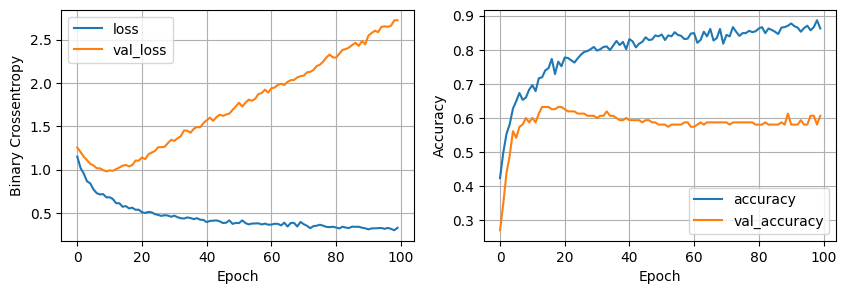

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6427 - loss: 2.1351
16 nodes, dropout 0.2, lr 0.001, batch size 64


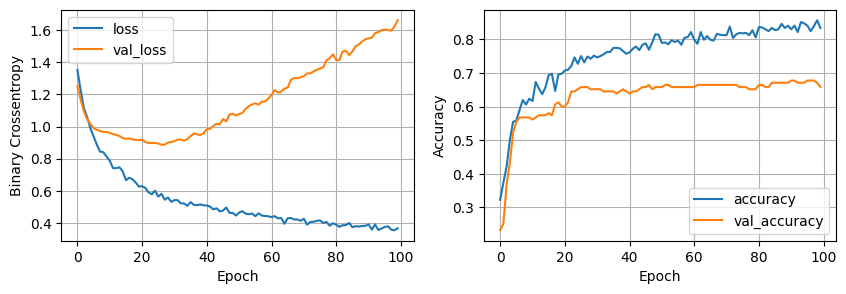

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6681 - loss: 1.4447 
16 nodes, dropout 0.2, lr 0.001, batch size 128


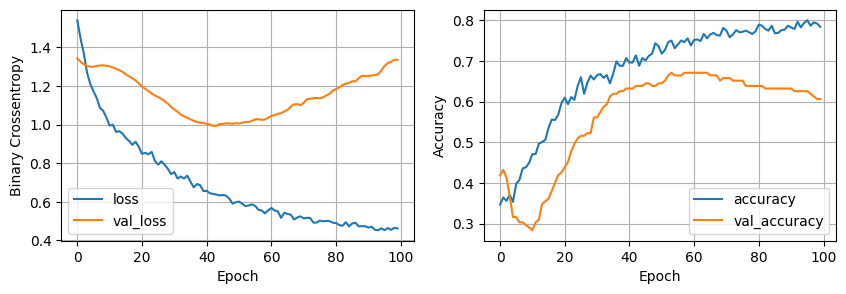

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6266 - loss: 1.2325 
32 nodes, dropout 0, lr 0.01, batch size 32


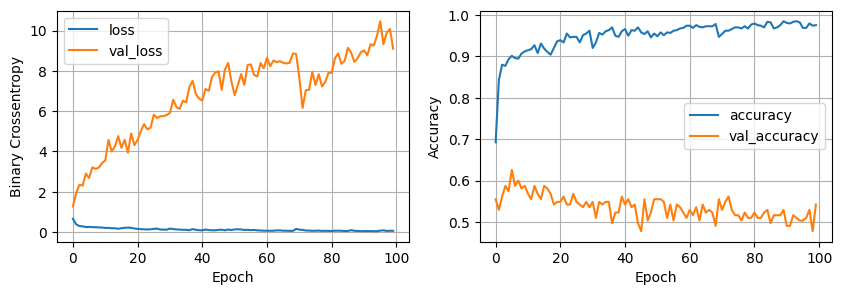

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5999 - loss: 6.4637
32 nodes, dropout 0, lr 0.01, batch size 64


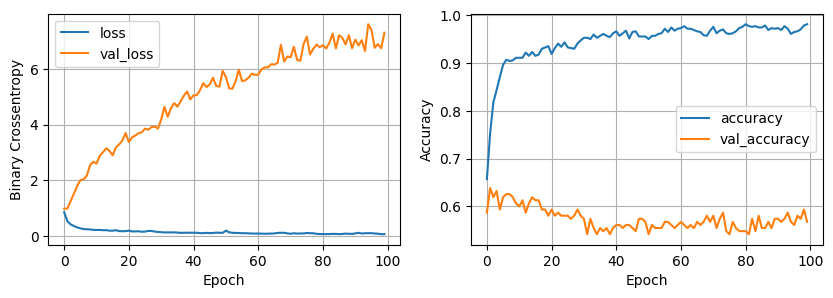

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6198 - loss: 4.9127
32 nodes, dropout 0, lr 0.01, batch size 128


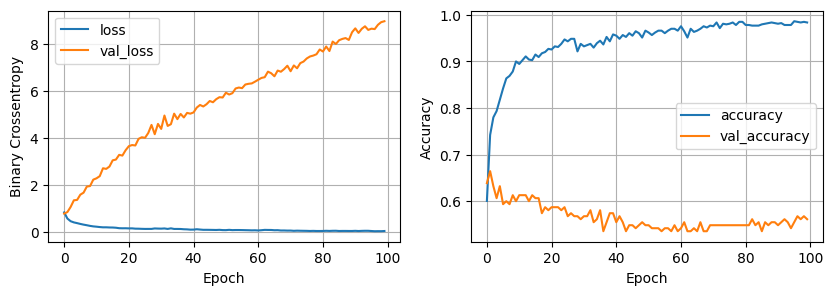

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6190 - loss: 5.7292 
32 nodes, dropout 0, lr 0.005, batch size 32


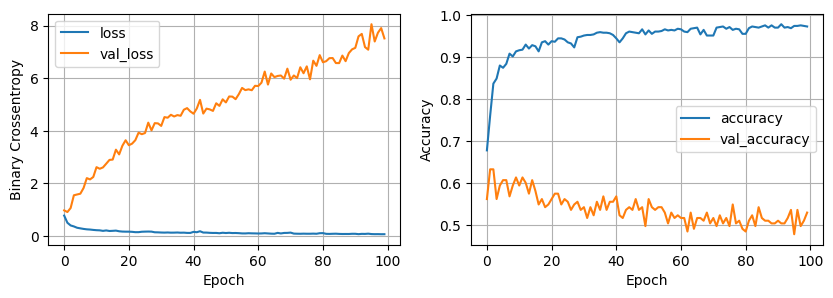

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 5.0175 
32 nodes, dropout 0, lr 0.005, batch size 64


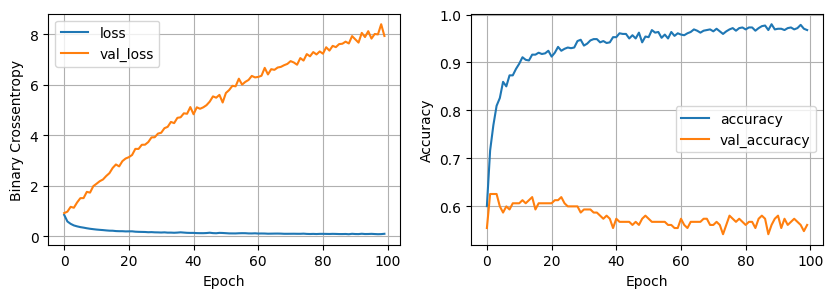

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6363 - loss: 4.9299 
32 nodes, dropout 0, lr 0.005, batch size 128


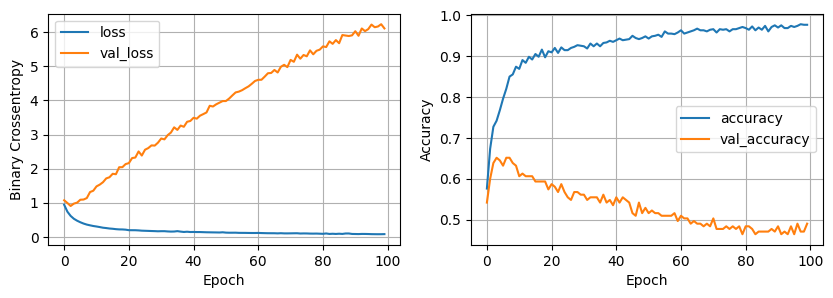

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5471 - loss: 4.2065 
32 nodes, dropout 0, lr 0.001, batch size 32


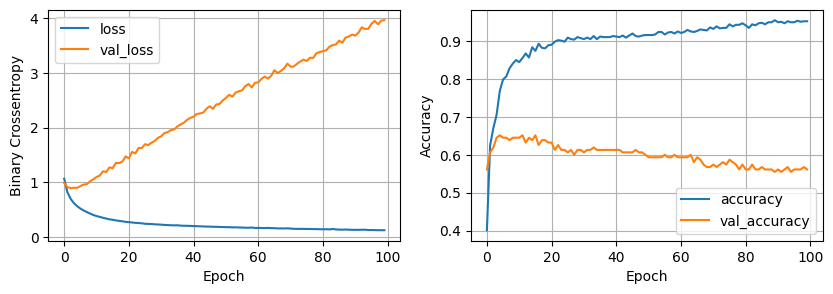

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6159 - loss: 2.5883
32 nodes, dropout 0, lr 0.001, batch size 64


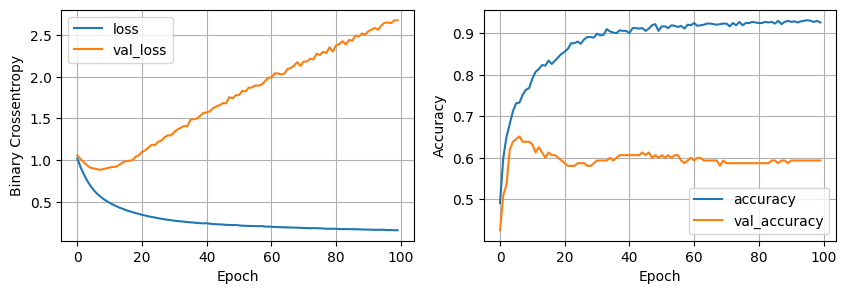

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6488 - loss: 1.9012 
32 nodes, dropout 0, lr 0.001, batch size 128


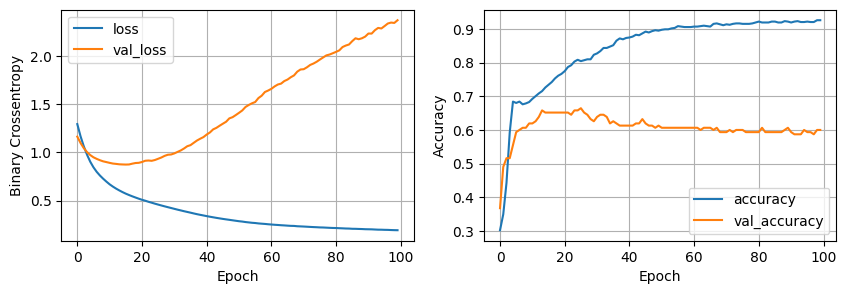

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6544 - loss: 1.7467 
32 nodes, dropout 0.2, lr 0.01, batch size 32


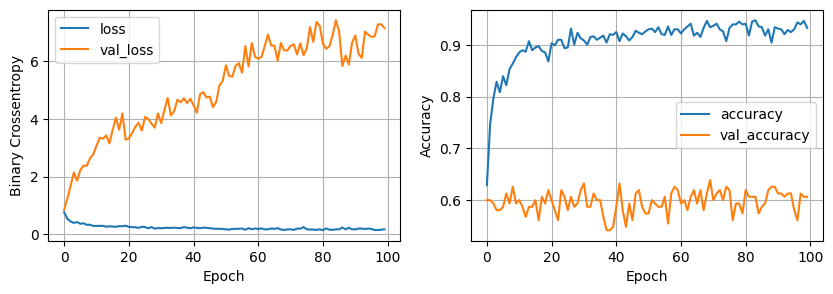

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6444 - loss: 5.0462 
32 nodes, dropout 0.2, lr 0.01, batch size 64


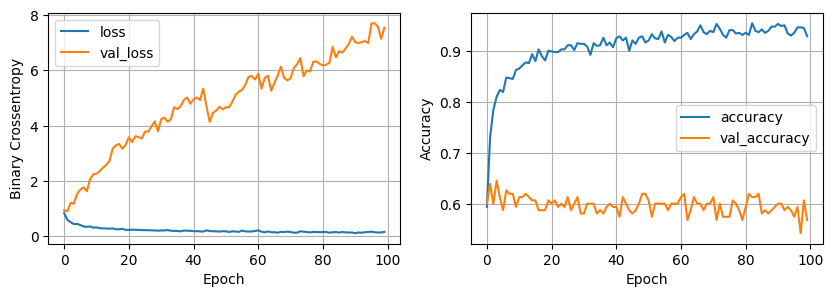

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6037 - loss: 5.0542 
32 nodes, dropout 0.2, lr 0.01, batch size 128


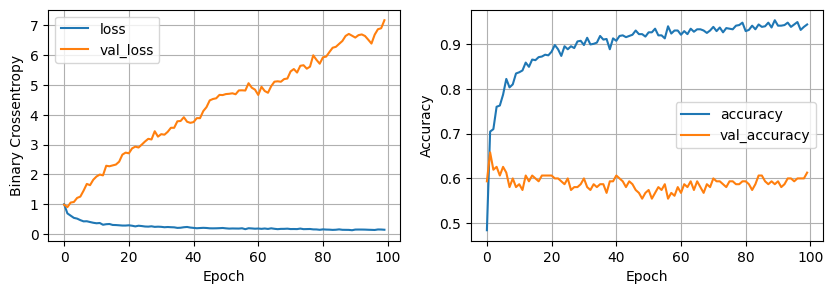

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6487 - loss: 5.0106 
32 nodes, dropout 0.2, lr 0.005, batch size 32


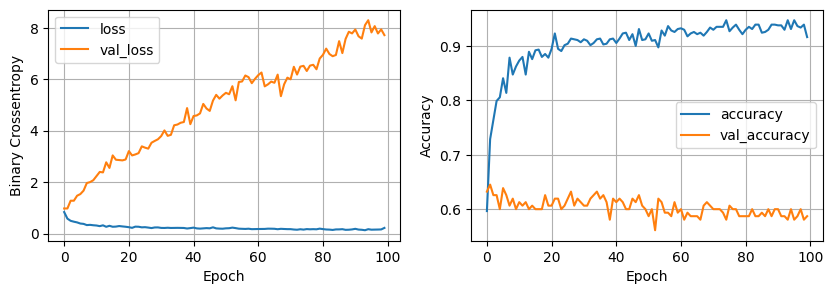

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6362 - loss: 5.1914 
32 nodes, dropout 0.2, lr 0.005, batch size 64


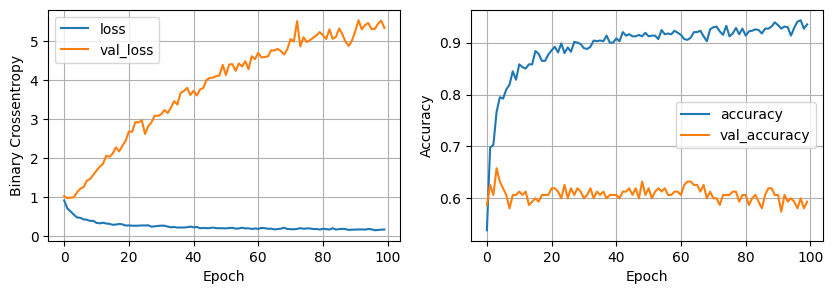

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6397 - loss: 3.7771 
32 nodes, dropout 0.2, lr 0.005, batch size 128


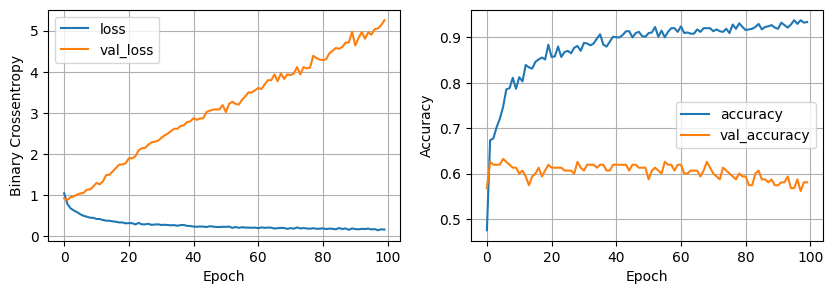

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6384 - loss: 3.6019 
32 nodes, dropout 0.2, lr 0.001, batch size 32


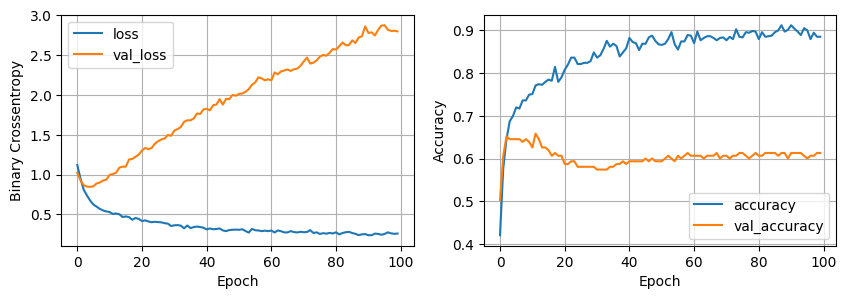

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6657 - loss: 2.1449 
32 nodes, dropout 0.2, lr 0.001, batch size 64


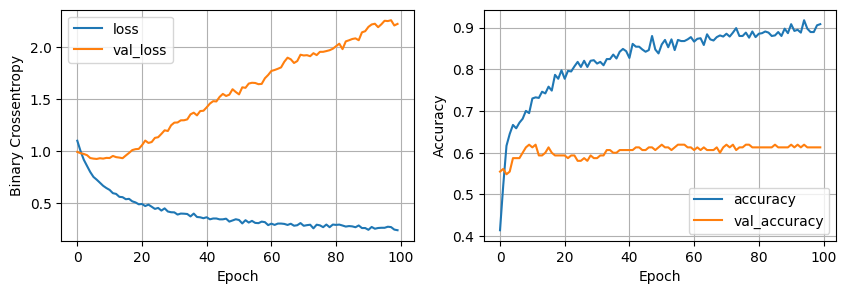

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6639 - loss: 1.7179
32 nodes, dropout 0.2, lr 0.001, batch size 128


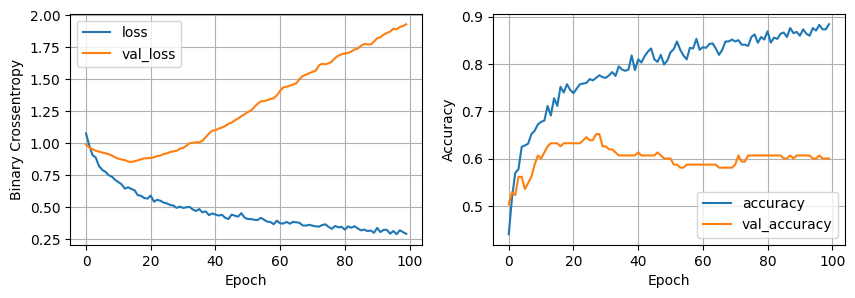

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6475 - loss: 1.4964 
64 nodes, dropout 0, lr 0.01, batch size 32


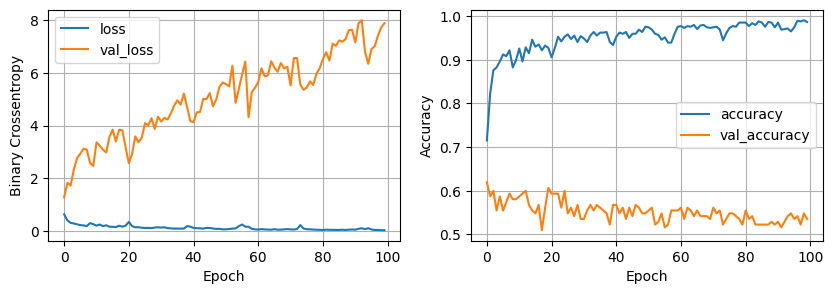

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5726 - loss: 6.0620
64 nodes, dropout 0, lr 0.01, batch size 64


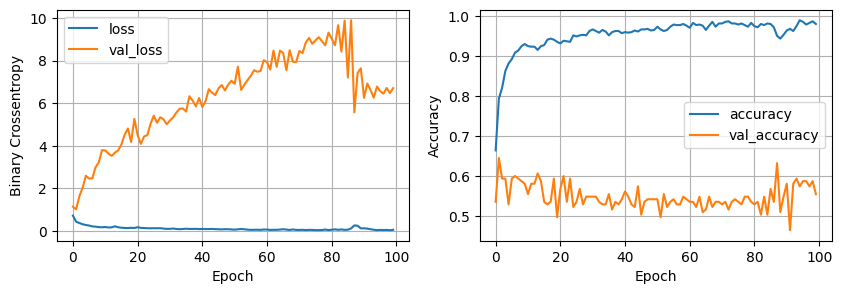

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5721 - loss: 5.5920 
64 nodes, dropout 0, lr 0.01, batch size 128


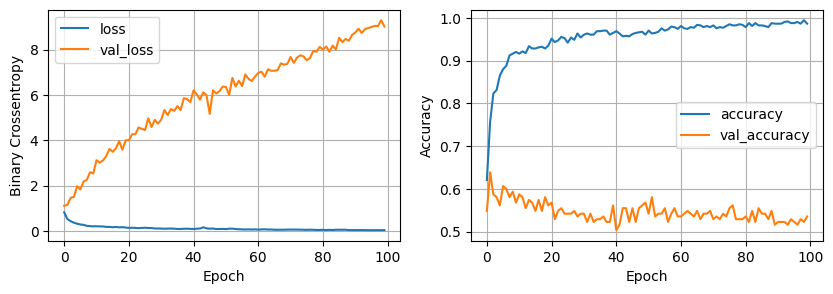

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5947 - loss: 6.3527 
64 nodes, dropout 0, lr 0.005, batch size 32


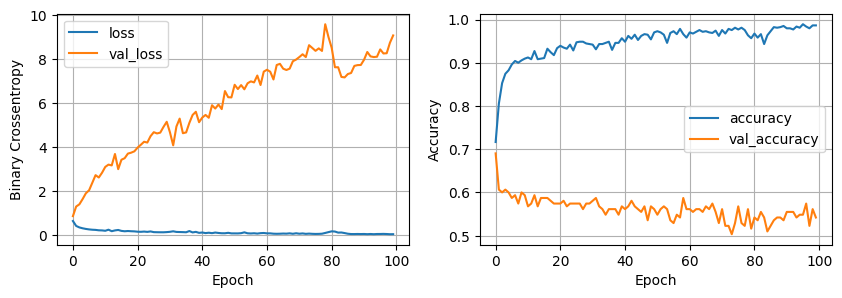

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5747 - loss: 6.1693 
64 nodes, dropout 0, lr 0.005, batch size 64


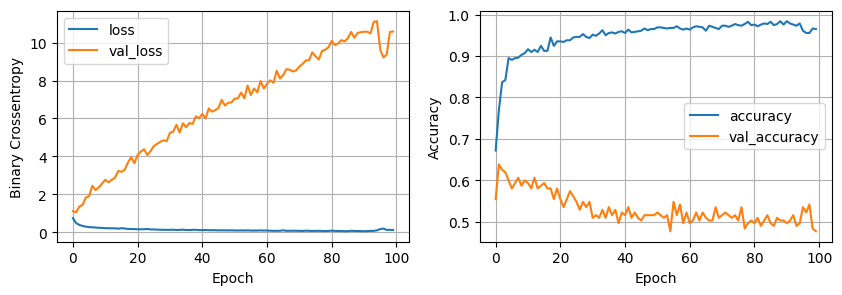

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5437 - loss: 6.6927 
64 nodes, dropout 0, lr 0.005, batch size 128


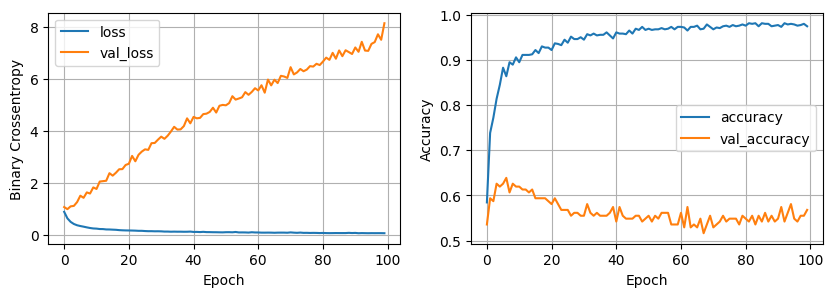

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6033 - loss: 5.4441
64 nodes, dropout 0, lr 0.001, batch size 32


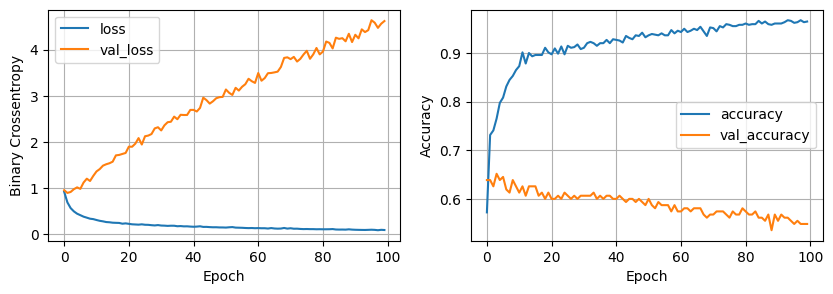

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5973 - loss: 3.2184 
64 nodes, dropout 0, lr 0.001, batch size 64


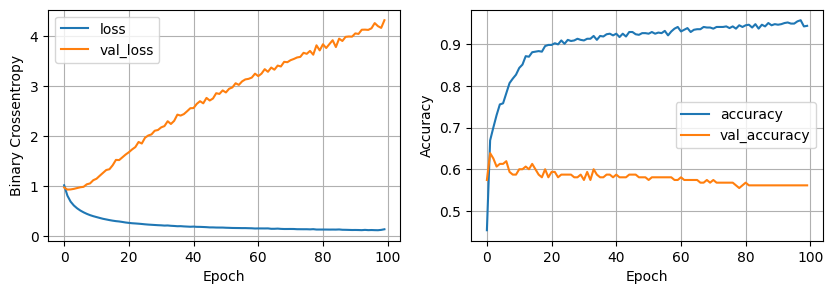

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6242 - loss: 2.9411 
64 nodes, dropout 0, lr 0.001, batch size 128


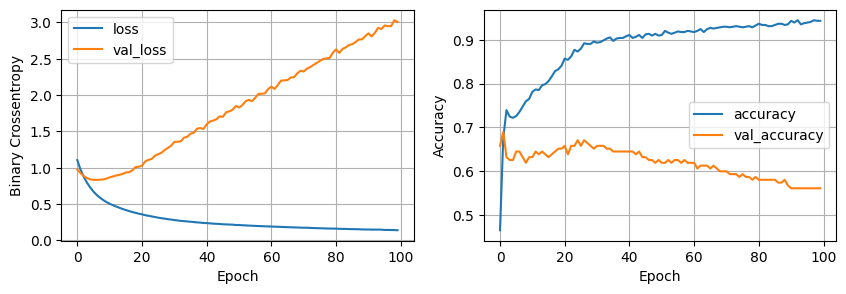

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6233 - loss: 2.2026 
64 nodes, dropout 0.2, lr 0.01, batch size 32


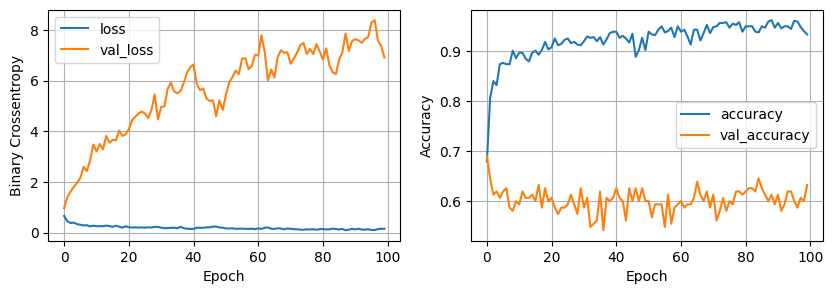

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6634 - loss: 5.1179 
64 nodes, dropout 0.2, lr 0.01, batch size 64


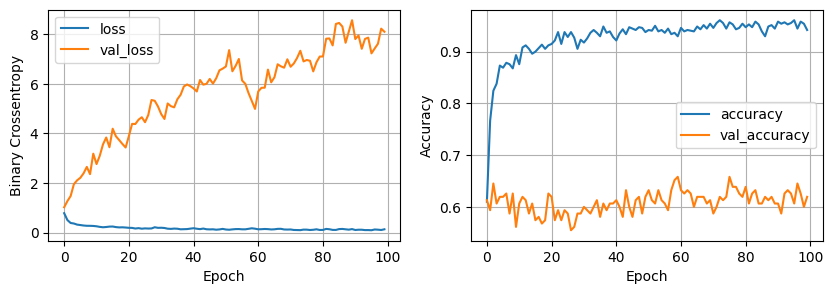

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6440 - loss: 5.7067 
64 nodes, dropout 0.2, lr 0.01, batch size 128


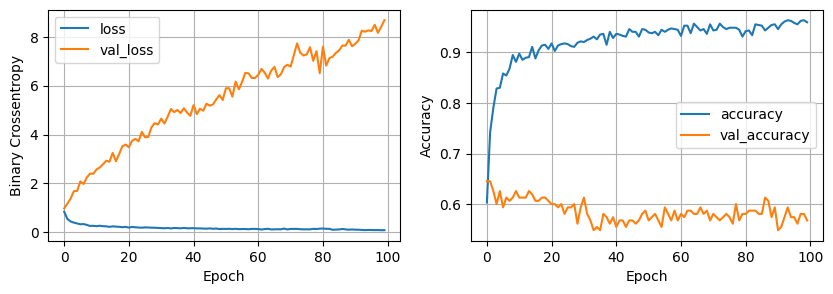

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6224 - loss: 5.6012 
64 nodes, dropout 0.2, lr 0.005, batch size 32


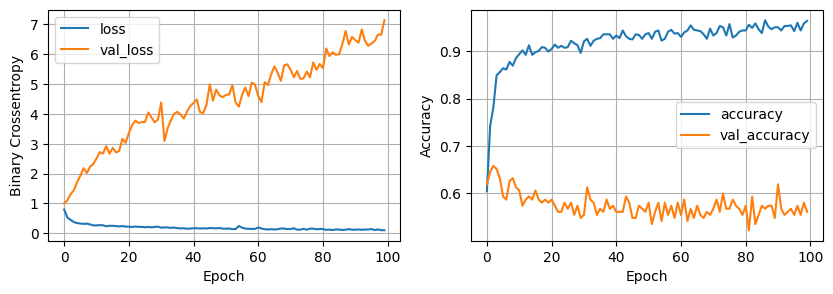

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6042 - loss: 5.5715 
64 nodes, dropout 0.2, lr 0.005, batch size 64


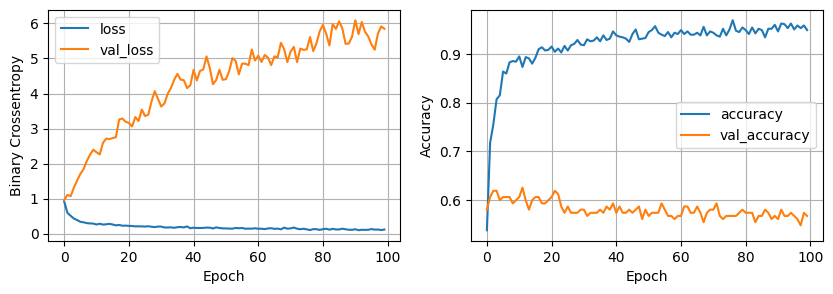

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6120 - loss: 4.2485 
64 nodes, dropout 0.2, lr 0.005, batch size 128


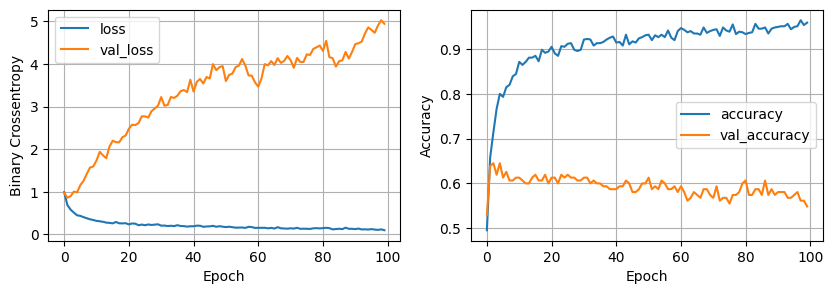

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6025 - loss: 3.6899 
64 nodes, dropout 0.2, lr 0.001, batch size 32


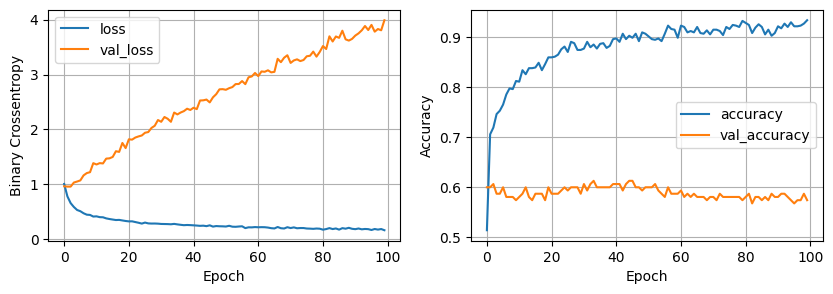

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6215 - loss: 2.8454 
64 nodes, dropout 0.2, lr 0.001, batch size 64


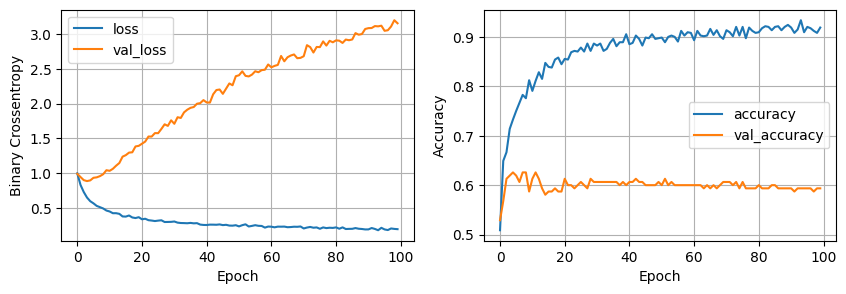

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6475 - loss: 2.2697 
64 nodes, dropout 0.2, lr 0.001, batch size 128


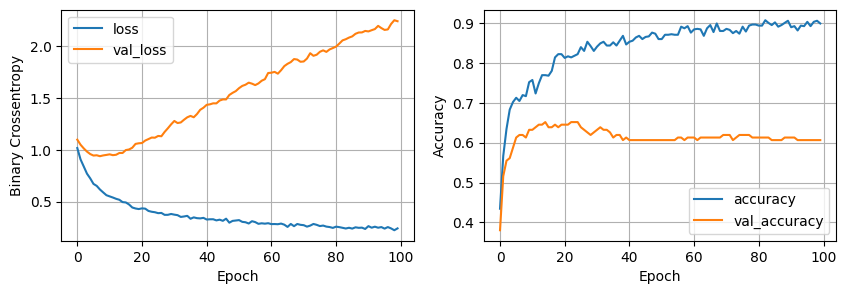

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6605 - loss: 1.7394 


In [86]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, Y_train , num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, Y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [87]:
print(least_val_loss)

1.3358595371246338


In [103]:
Y_pred = least_loss_model.predict(X_test)
Y_pred = (Y_pred == Y_pred.max(axis=1, keepdims=True)).astype(int)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = Y_test.astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [104]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.53      0.67        72
           1       0.00      0.00      0.00         5
           2       0.71      0.47      0.56        79

    accuracy                           0.48       156
   macro avg       0.55      0.33      0.41       156
weighted avg       0.79      0.48      0.60       156



Used down-sampling to make sure model learns categories 1 and 2, it only learned 2. Need better error analysis.